# Model Evaluation

## Configuration file

In [57]:
configuration = 'training.yaml'
num_hours_for_normal_traffic = 12

In [58]:
import os, sys
src_dir = os.environ['BASKERVILLE_ROOT'] + '/src'
if not os.path.lexists(src_dir):
    raise RuntimeError('Baskerville source dir does not exist!')
module_path = os.path.abspath(os.path.join(src_dir))
if module_path not in sys.path:
    sys.path.append(module_path)
print(src_dir)

/home/spark/baskerville/src


In [59]:
from pyspark import SparkConf
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, StructField, StructType, DoubleType
from pyspark.sql import SparkSession
conf = SparkConf()
# conf.set('spark.driver.host', 'localhost' )
# conf.set('spark.master', 'local[10]')

conf.set('spark.driver.host', 'localhost' )
conf.set('spark.master', 'local[10]')
# spark://$SPARK_MASTER_HOST:7077
        
conf.set("spark.hadoop.dfs.client.use.datanode.hostname", True)
conf.set('spark.jars', os.environ['BASKERVILLE_ROOT'] + '/data/jars/postgresql-42.2.4.jar')
conf.set('spark.executor.memory', '40G')
conf.set('spark.memory.offHeap.enabled', 'true')
conf.set('spark.memory.offHeap.size', '35G')

# conf.set('parallelism', -1)

spark = SparkSession \
    .builder.config(conf=conf) \
    .appName("NotebookModelEvaluation") \
    .getOrCreate()

In [60]:
from baskerville.db.models import Attack, Attribute
from baskerville.util.helpers import parse_config
from baskerville.models.config import BaskervilleConfig
from baskerville.util.baskerville_tools import BaskervilleDBTools
from baskerville.models.anomaly_model import AnomalyModel
import time
from datetime import datetime, timedelta
import itertools
os.environ['TZ'] = 'UTC'
time.tzset()
conf_path = os.environ['BASKERVILLE_ROOT'] + f'/conf/{configuration}'
config = parse_config(path=conf_path)
config = BaskervilleConfig(config)
# features = config.engine.extra_features

# config.database.maintenance = None
# db_tools = BaskervilleDBTools(config.database)
# db_tools.connect_to_db()

In [61]:
from pyspark.sql.types import *
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from baskerville.db import get_jdbc_url

def load_dataset(query, spark, db_config):
    db_url = get_jdbc_url(db_config)
    conn_properties = {
        'user': db_config.user,
        'password': db_config.password,
        'driver': 'org.postgresql.Driver',
    }
    df = spark.read.jdbc(
            url=db_url,
            table=query,
            properties=conn_properties
        )
#     df = df.limit(100)
    json_schema = spark.read.json(df.limit(1).rdd.map(lambda row: row.features)).schema
#     json_schema.add(StructField(
#         name='host_country',
#         dataType=StringType(),
#         nullable=True))
    df = df.withColumn('features1', F.from_json('features', json_schema))
    df = df.withColumn('features', F.create_map(
        *list(itertools.chain(*[(F.lit(f), F.col('features1').getItem(f)) for f in json_schema.__dict__['names']])
             ))).drop('features1')
    
#     df = df.withColumn('features.host_country', F.concat(F.col("features.host"), F.lit("_"), F.col("features.country")))

    return df

def evaluate_model(models, spark, db_config):
    config.database.maintenance = None
    db_tools = BaskervilleDBTools(db_config)
    db_tools.connect_to_db()

    attacks = db_tools.session.query(Attack).all()
    result = []
    for attack in attacks:
        if attack.id < 21:
            continue
            
        print(f'Processing attack {attack.id}: start={attack.start}, stop={attack.stop}')
        
        if attack.id == 9: # manually filtered by Vladimir
            attack_ips = []  # todo: load from csv
        else:
            attack_ips = [a.value for a in attack.attributes]

        attack_ips = spark.createDataFrame(data=[[a] for a in attack_ips], 
                                    schema=StructType([StructField("ip_attacker", StringType())]))
    
        
        print('Querying database...')
#         query = f'(select ip, target, created_at, features, stop from request_sets where '\
#             f'target=\'{attack.target}\' and '\
#             f'stop > \'{attack.start-timedelta(hours=num_hours_for_normal_traffic)}\' and stop < \'{attack.stop}\') as attack1'

#         query = f'(select ip, target, created_at, features, stop from request_sets where '\
#             f'stop > \'2020-07-31 00:00:00Z\' and stop < \'2020-07-31 00:30:00Z\') as attack1 '

    
        query = f'(select ip, target, created_at, features, stop from request_sets where '\
            f'stop > \'{attack.start.strftime("%Y-%m-%d %H:%M:%S")}Z\' and stop < \'{attack.stop.strftime("%Y-%m-%d %H:%M:%S")}Z\') as attack1 '

            
#         query = f'(select ip, target, created_at, features, stop from request_sets where '\
#             f'stop > \'{attack.start}\' and stop < \'{attack.stop}\') as attack1 '



        rs = load_dataset(query, spark, db_config)
        num_records = rs.count()
        print(f'Loaded {num_records} records')
        if num_records == 0:
            print(f'Skipping attack {attack.id}, no records found.')
            continue
        print('Joining the labels...')
        rs = rs.join(attack_ips, rs.ip == attack_ips.ip_attacker, how='left')
        rs = rs.withColumn('label', F.when(F.col('ip_attacker').isNull(), 0.0).otherwise(1.0))
        
        aucs = []
        for model in models:
            print('Predicting...')
            rs1 = model.predict(rs)
            print('Calculating metrics...')
            metrics = BinaryClassificationMetrics(rs1.select(['score', 'label']).rdd)
            auc = metrics.areaUnderPR
            print(f'Area under PR curve = {auc}')
            aucs.append(auc)
        result.append((attack, aucs))
        
    db_tools.disconnect_from_db()
    
    return result

In [62]:
model_0 = AnomalyModel()
model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_10_08___14_22', 
             spark) # host balance 5K, no totals, no host_counry - 

# model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_08_14___20_23', 
#              spark) # host balance 5K, no totals, no counry - 0.9789

# model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_09_18___16_39', 
#              spark) # host balance 5K, no totals, with host_counry - 0.9793

# model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_09_17___17_20', 
#              spark) # host balance 5K, no totals, with counry - 0.9786

# model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_08_14___20_23', 
#              spark) # host balance 5K, no totals, no counry - 0.9789


# model_0.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_07_10___18_33', spark) # baseline - 0.905
# model_0.load('hdfs://hadoop-01:8020/prod/models#/AnomalyModel__2020_07_10___19_19', spark) # host balance 10K - 0.908


In [63]:
model_1 = AnomalyModel()
model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_10_08___15_32', 
             spark) # host balance 5K, no totals, with host_counry - 

# model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_09_18___16_39', 
#              spark) # host balance 5K, no totals, with host_counry - 0.9793

# model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_07_10___18_52', spark) # host balance 30K - 0.907
# model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_07_10___19_03', spark) # host no balance
# model_1.load('hdfs://hadoop-01:8020/prod/models/', spark) # host and country
# model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_07_10___19_19', spark) # host balance 10K
# model_1.load('hdfs://hadoop-01:8020/prod/models/AnomalyModel__2020_07_10___19_35', spark) # host balance 5K - 0.912



In [2]:
metrics = evaluate_model([model_0, model_1], spark, config.database)

NameError: name 'evaluate_model' is not defined

In [9]:
30K vs 10K
Processing attack 9: target=test_target1, start=2020-07-05 14:28:00+00:00, stop=2020-07-05 14:46:00+00:00
Querying database...
Joining the labels...
Predicting...
Calculating metrics...
Area under PR curve = 0.7426313311752667
Predicting...
Calculating metrics...
Area under PR curve = 0.7464435760046548
Processing attack 10: target=test_target2, start=2020-07-09 08:34:00+00:00, stop=2020-07-09 09:56:00+00:00
Querying database...
Joining the labels...
Predicting...
Calculating metrics...
Area under PR curve = 0.5565857543950203
Predicting...
Calculating metrics...
Area under PR curve = 0.5772456757943066

SyntaxError: invalid syntax (<ipython-input-9-1e4c4a61c708>, line 1)

In [22]:
aucs1

[0.43709868383764366,
 0.41462596125307394,
 0.6637837954274215,
 0.5554267897458155,
 0.9751537166473505,
 0.6009327437470678,
 0.6946824777025093]

In [36]:
labels = ['baseline', 'host_country']
x_labels = [f'{a.id}' for a, _ in metrics]
aucs1 = [v for _, (v, _) in metrics]
aucs2 = [v for _, (_, v) in metrics]


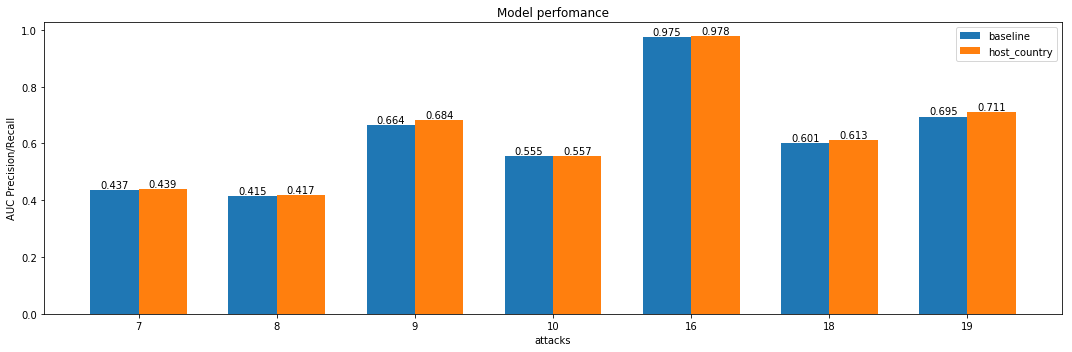

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x = np.arange(len(x_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, aucs1, width, label=labels[0])
rects2 = ax.bar(x + width/2, aucs2, width, label=labels[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC Precision/Recall')
ax.set_xlabel('attacks')
ax.set_title('Model perfomance')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

# Attack 2020-07-05 14:28:00Z - 2020-07-05 14:46:00Z

In [24]:
target = 'test_target'
table = 'request_sets_y2020_w27'
attack_start = '2020-07-05 14:28:00Z'
attack_stop = '2020-07-05 14:46:00Z'
regular_start = '2020-07-04 14:46:00Z'
regular_stop = '2020-07-05 09:46:00Z'

In [28]:
query = f'(select ip, target, created_at, features, stop, score from request_sets_y2020_w27 where '\
    f'stop > \'{attack_start}\' and stop < \'{attack_stop}\') as attack1'
df = load_dataset(query, spark, config.database)

In [ ]:
df = df.toPandas()

In [34]:
len(df)

69226

In [71]:
attackers = df[df['score'] > 0.45]

In [72]:
len(attackers)

10353

In [73]:
attack_ips = attackers['ip'].unique()

In [1]:
len(attack_ips)

NameError: name 'attack_ips' is not defined

1298